In [13]:
cd .. 

C:\Projects\Work\kenul


In [17]:
%load_ext autoreload
%autoreload 2
import warnings
from pathlib import Path
import pickle
from matplotlib import pyplot as plt

import numpy as np

import mne
import colorednoise as cn

import random

from scipy import signal, stats

from datetime import datetime, timezone
import time
import uuid

import func
import swd_io
import raw2xdf
import collections
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 9C64-821C

 Directory of C:\Projects\Work\kenul\swd_analysis

11.06.2023  00:49    <DIR>          .
11.06.2023  00:49    <DIR>          ..
27.05.2023  18:55             1 996 .gitignore
27.05.2023  20:59    <DIR>          .ipynb_checkpoints
28.02.2021  01:23    <DIR>          .jupyter_symlinks
02.12.2021  23:54               236 .test_file_path
03.12.2021  00:10               468 .test_file_path.json
26.06.2021  19:47    <DIR>          .vscode
10.12.2022  21:37                 0 __init__.py
11.06.2023  00:48    <DIR>          __pycache__
20.01.2021  11:34    <DIR>          build
11.06.2023  00:53         2 811 188 callgrind.gui_main.kgrind
04.10.2022  01:21               279 config.ini
04.10.2022  00:20             1 010 config.py
11.12.2022  07:32               905 containers.py
28.12.2021  16:26    <DIR>          dist
11.06.2023  00:48            25 534 eeg_widgets.py
10.06.2023  20:26         1 203 411 fast.prof
04.06.2023  20:0

## Generate SWD segments & check spectral characteristics

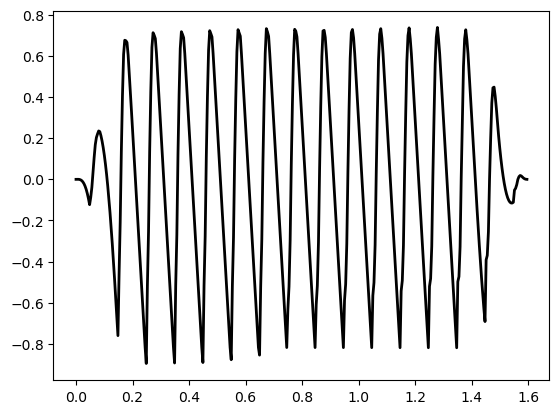

In [4]:
%matplotlib inline
def create_swd_segment(nsamp, sfreq=250, dom_freq=10, freq_wiggle=0, phase_wiggle=0, n_sawtooth=1, st_max=0.1, asymmetry=0):
    ts = np.linspace (0, nsamp/sfreq, nsamp)
    window = signal.windows.tukey(len(ts), alpha=0.25)
    swd = np.zeros(ts.shape)
    st = np.linspace(0, st_max, n_sawtooth)
    np.random.shuffle(st)
    for width in st:
        freq = dom_freq + np.random.normal()*freq_wiggle
        phase = np.pi - np.pi*np.random.normal()*phase_wiggle
        
        new_swd = signal.sawtooth(2 * np.pi * freq *ts - phase, width=width)
        # plt.plot(ts, new_swd)
        swd += new_swd
    swd = swd/n_sawtooth
    swd *= window
    swd += window*asymmetry
    
    return ts, swd   

samples = 399

swd_scale = 10

ts, seg = create_swd_segment(samples, sfreq=250, dom_freq=10, st_max=0.3, n_sawtooth=10, freq_wiggle=0.05, phase_wiggle=0.1, asymmetry=0)


plt.plot(ts, seg, color='black', linewidth=2)

In [41]:
def create_swd_framgents_from_annotations(eeg):
    eeg.swd_data = {}
    eeg.swd_state = {}

    for ch_name in eeg.annotation_dict:
        eeg.swd_data[ch_name] = {}
        eeg.swd_state[ch_name] = {}

        for swd_uuid, annotation in eeg.annotation_dict[ch_name].items():
            channel = eeg.raw.info['ch_names'].index(ch_name)
            fragment = eeg.raw[channel][0][0][int(annotation['onset']):int(annotation['onset']+ annotation['duration'])]
            eeg.swd_data[ch_name][swd_uuid] = fragment
            eeg.swd_state[ch_name][swd_uuid] = True

def create_simulated_eeg(
                    sfreq=250,
                    channels = ['a'],
                    length_sec = 60*60*2,
                    noise_scale = 1,
                    edf_filename = 'test.edf',

                    #swd
                    n_segments = 100,
                    mean_segment_length = 1000,
                    dom_freq = 10,
                    freq_sd = 0.5,
                    swd_scale = 10,
                    swd_scale_sd = 2,
                    asym = 0,
                    asym_sd = 0.1):


    eeg_nsamp = length_sec*sfreq
    # timestamp = datetime.now(tz=timezone.utc)
    timestamp = time.time()

    noise = [cn.powerlaw_psd_gaussian(exponent=1, size=eeg_nsamp, random_state=None) for a in channels]
    noise = np.c_[noise]*noise_scale
    raw = mne.io.RawArray(noise, mne.create_info(channels, sfreq, ch_types=['eeg' for a in channels]), verbose=0)
    raw.set_meas_date(timestamp)

    eeg = func.EEG()
    eeg.raw = raw
    eeg.raw.crop(0.1, length_sec-1)


    len_dist = np.random.normal(mean_segment_length, 500, 1000)
    len_dist = len_dist[len_dist>sfreq]

    freq_dist = np.random.normal(dom_freq, freq_sd, 1000)
    scale_dist = np.random.normal(swd_scale, swd_scale_sd, 1000)
    asym_dist = np.random.normal(asym, asym_sd, 1000)


    freq_segments = np.random.choice(freq_dist, size=n_segments)
    len_segments = np.random.choice(len_dist, size=n_segments).astype(int)
    scale_segments = np.random.choice(scale_dist, size=n_segments)
    asym_segments = np.random.choice(asym_dist, size=n_segments)

    segs = [create_swd_segment(l, sfreq=sfreq, dom_freq=f, asymmetry=a, 
                               st_max=0.3, n_sawtooth=10, freq_wiggle=0.05, phase_wiggle=0.1)[1] for l, f, a in zip(len_segments, freq_segments, asym_segments)]

    starts = sorted(np.random.choice(np.linspace(np.max(len_segments), raw._data.shape[1]-np.max(len_segments)*10, n_segments*10).astype(int)[:-1], n_segments))



    if not hasattr(eeg, 'annotation_dict'):
        eeg.annotation_dict = {a:collections.OrderedDict() for a in eeg.raw.info['ch_names']}
        eeg.swd_uuid_dict = {a:[] for a in eeg.raw.info['ch_names']}
        eeg.dataset_name = {a:a for a in eeg.raw.info['ch_names']}
        eeg.dataset_uuid = {a:str(uuid.uuid4()) for a in eeg.raw.info['ch_names']}

    events = []
    for seg, start, scale in zip(segs, starts, scale_segments):
        swd_uuid = uuid.uuid4()
        eeg.annotation_dict[channels[0]][swd_uuid] = dict(onset = start,
                        duration = len(seg),
                orig_time = eeg.raw.annotations.orig_time)
        eeg.swd_uuid_dict[channels[0]].append(swd_uuid)
        events.extend([[start, 0, 0], [start+len(seg), 0, 1]])

        eeg.raw._data[0, start:start+len(seg)] += (seg*scale)

    create_swd_framgents_from_annotations(eeg)
    
    eeg.filename = edf_filename
    fn = eeg.filename + '.pickle'
    swd_io.save_eeg_processing(eeg, fn)
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")   
        raw2xdf.write_npy_edf(eeg.raw._data, eeg.raw.info, edf_filename, overwrite=True)


    
    
# mne.viz.set_browser_backend('qt')
# eeg.raw.plot(scalings={'eeg':noise_scale*10},duration=60, events=np.array(events))


Create simulated EDF files using 3 samples with 20 files in each
30-50 SWD in each

Difference between samples is amplitude, spectrum and asummetry in different combinations


In [ ]:

for i in tqdm(range(20)):
    create_simulated_eeg(edf_filename=f'test_data/sim/ampl/1/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60))
    create_simulated_eeg(edf_filename=f'test_data/sim/ampl/2/{i}.edf', swd_scale=9, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60))
    create_simulated_eeg(edf_filename=f'test_data/sim/ampl/3/{i}.edf', swd_scale=11, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60))
    
    

In [ ]:
for i in tqdm(range(20)):
    create_simulated_eeg(edf_filename=f'test_data/sim/asymm/1/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), asym=0.5)
    create_simulated_eeg(edf_filename=f'test_data/sim/asymm/2/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), asym=0)
    create_simulated_eeg(edf_filename=f'test_data/sim/asymm/3/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), asym=-0.5)
    
    

In [ ]:
for i in tqdm(range(20)):
    create_simulated_eeg(edf_filename=f'test_data/sim/freq/1/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), dom_freq=10.5)
    create_simulated_eeg(edf_filename=f'test_data/sim/freq/2/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), dom_freq=10)
    create_simulated_eeg(edf_filename=f'test_data/sim/freq/3/{i}.edf', swd_scale=7, swd_scale_sd=1, freq_sd=1, n_segments = random.randint(40, 60), dom_freq=9.5)
    
    